# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: ID

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

In [4]:
training_set.shape

(2000, 3)

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

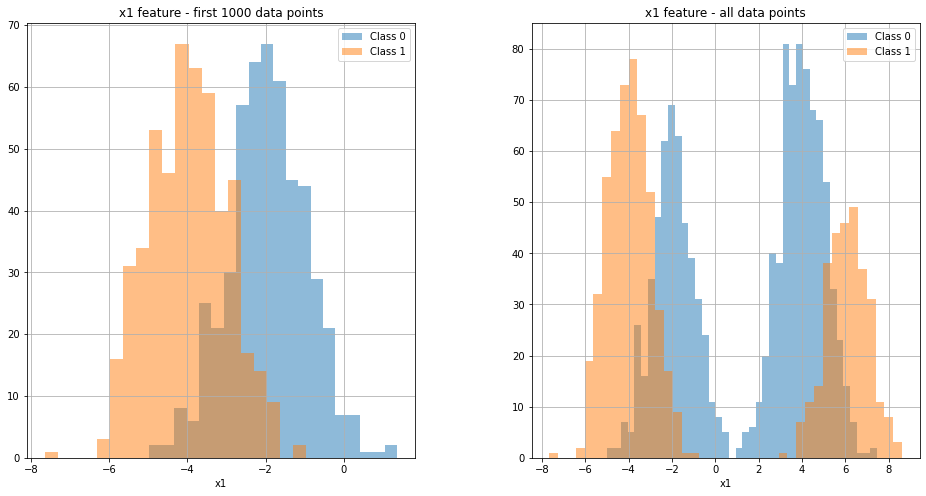

In [5]:
#### Your code here ####

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

training_set[['x1','y']][:1000].groupby('y').hist(ax=ax[0] ,bins=20, alpha=0.5)
training_set[['x1','y']].groupby('y').hist(ax=ax[1], bins=40, alpha=0.5)

ax[0].set_title('x1 feature - first 1000 data points')
ax[1].set_title('x1 feature - all data points')

ax[0].set_xlabel('x1')
ax[1].set_xlabel('x1')

ax[0].legend(['Class 0','Class 1'])
ax[1].legend(['Class 0','Class 1'])

plt.show()

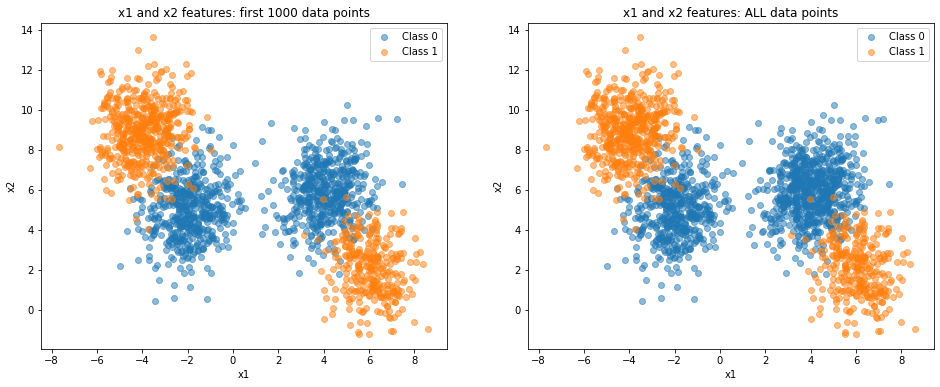

In [6]:
class0 = training_set[training_set['y'] == 0]
class1 = training_set[training_set['y'] == 1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].scatter(data=training_set[training_set['y'] == 0][:1000], x='x1', y='x2', alpha=0.5, label='Class 0')
ax[0].scatter(data=training_set[training_set['y'] == 1][:1000], x='x1', y='x2', alpha=0.5, label='Class 1')

ax[1].scatter(data=training_set[training_set['y'] == 0], x='x1', y='x2', alpha=0.5, label='Class 0')
ax[1].scatter(data=training_set[training_set['y'] == 1], x='x1', y='x2', alpha=0.5, label='Class 1')

ax[0].set_title('x1 and x2 features: first 1000 data points')
ax[1].set_title('x1 and x2 features: ALL data points')

for ax_i in ax:
    ax_i.set_xlabel('x1')
    ax_i.set_ylabel('x2')
    ax_i.legend()

plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [7]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        
        self.thetas = None
        self.J_history = []
        self.instance_num = None

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        np.random.seed(self.random_state)
        # num of instances
        self.instance_num = len(y) 
        # add bias
        X = np.c_[np.ones(self.instance_num), X]
        # initialize theta
        self.thetas = np.random.random(X.shape[1])
        self.gradient_descent(X, y)
    
    
    def predict(self, X):
        """Return the predicted class label"""
        X_w_bias = np.c_[np.ones(len(X)), X]
        return np.round(self.sigmoid(X_w_bias @ self.thetas))
    
    
    def sigmoid(self, X):
        exponent = np.exp(X)
        return exponent / (1 + exponent)
    
    
    def gradient_descent(self, X, y):
        theta = self.thetas.copy()
        J_history = []
        delta_J = np.inf
        
        for i in range(self.n_iter):
            h = self.sigmoid(X @ theta)
            theta -= (self.eta / self.instance_num)*X.T @ (h - y)
            J_i = self.compute_cost(X, y, theta)
            J_history.append(J_i)
            
            if len(J_history) > 1:
                delta_J = abs(J_history[i] - J_history[i - 1])
            
            if delta_J <= self.eps:
                break
                
        self.thetas = theta
        self.J_history = J_history
    
    
    def compute_cost(self, X, y, theta):
        h = self.sigmoid(X @ theta)
        J = (1 / self.instance_num) * (((-y) @ np.log(h)) - ((1 - y) @ np.log(1 - h)))
        return J

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [8]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

folds_num = 5
instance_num = X_training.shape[0]
fold_mean_accuracy_df = pd.DataFrame(index=epss, columns=etas)

np.random.seed(1)

train_indecies = np.arange(instance_num)
np.random.shuffle(train_indecies)
X_train_shuffled, y_train_shuffled = X_training[train_indecies], y_training[train_indecies]


best_accuracy = -np.inf
temp_best_eps, temp_best_eta = None, None
count = 1
loops_num = len(etas) * len(epss)
step = instance_num // folds_num

for eta in etas:
    for eps in epss:
        fold_accuracy = []

        for i in range(0, instance_num, step):
            curr_X_training_set = np.concatenate((X_train_shuffled[0:i], X_train_shuffled[i + step:]))
            curr_y_training_set = np.concatenate((y_train_shuffled[0:i], y_train_shuffled[i + step:]))

            curr_X_val_set, curr_y_val_set = X_train_shuffled[i:i + step], y_train_shuffled[i:i + step]

            model = LogisticRegressionGD(eta=eta, eps=eps)
            model.fit(curr_X_training_set, curr_y_training_set)
            y_pred = model.predict(curr_X_val_set)

            accuracy = np.mean(y_pred == curr_y_val_set)
            fold_accuracy.append(accuracy)

        fold_accuracy_mean = np.mean(fold_accuracy)
        fold_mean_accuracy_df.loc[eps,eta] = fold_accuracy_mean

        if fold_accuracy_mean > best_accuracy:
            temp_best_eps, temp_best_eta = eps, eta
            best_accuracy = fold_accuracy_mean

best_eta, best_eps = temp_best_eta, temp_best_eps
print(f'Best Average Fold Accuracy: {best_accuracy:.3f}')
print(f'Best Params: eta - {best_eta}, eps - {best_eps}')
print('Accuracy Data Frame:')
fold_mean_accuracy_df

Best Average Fold Accuracy: 0.793
Best Params: eta - 0.05, eps - 1e-06
Accuracy Data Frame:


,0.050000,0.005000,0.000500,0.000050,0.000005
0.010000,0.493,0.395,0.3775,0.3775,0.3775
0.001000,0.548,0.537,0.394,0.3775,0.3775
0.000100,0.569,0.5345,0.5485,0.394,0.3775
0.000010,0.6515,0.5655,0.5325,0.642,0.381
0.000001,0.793,0.651,0.565,0.642,0.381


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [9]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    return np.exp( -(((data - mu) / sigma) ** 2) / 2) / (sigma * np.sqrt(2 * np.pi))

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [10]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = 1

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        
        self.w = np.ones(self.k) / self.k
        self.mu = np.array([(i / self.k) * np.mean(data) for i in range(1, self.k + 1)])
        self.std = np.array([(i / self.k) * np.std(data) for i in range(1, self.k + 1)])
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        
        likelihood = np.multiply(np.hstack(norm_pdf(data, self.mu[i], self.std[i])[:, np.newaxis] for i in range(len(self.mu))), self.w)
        responsibilities = likelihood / likelihood.sum(axis=1)[:,None]
        return responsibilities,likelihood

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        
        w = self.responsibilities.mean(axis=0)
        mu = (self.responsibilities.T @ data[:,None] / (self.w[:,None] * data.shape[0])).ravel()
        std = np.sqrt(np.mean(np.multiply(self.responsibilities, np.square(np.array(data)[:, np.newaxis] - self.mu)), axis=0) / self.w)
        return w, mu, std

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        
        self.init_params(data)
        self.log_likelihood = -np.inf
        
        for _ in range(self.n_iter):
            self.responsibilities,likelihood = self.expectation(data)
            log_likelihood = -1 * np.sum(np.log(likelihood.sum(axis=1)))
            
            old_log_likelihood = self.log_likelihood
            self.log_likelihood = -1*np.sum(np.log(likelihood))
            
            if np.isinf(self.log_likelihood) or (np.abs(self.log_likelihood-old_log_likelihood) <= self.eps):
                break
            
            new_w, new_mu, new_std = self.maximization(data)
            self.w = new_w
            self.mu = new_mu
            self.std = new_std

    def get_dist_params(self):
        return self.w, self.mu, self.std
    

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [11]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        
        # get prior of the two classes
        self.prior_0 = self.get_prior(y, 0)
        self.prior_1 = 1 - self.prior_0

        # EM - class 0 feature 0
        class_0_inds = y == 0
        x_class_0_x_0 = X[class_0_inds,0]
        self.em_class_0_x_0 = EM(k=self.k)
        self.em_class_0_x_0.fit(x_class_0_x_0)

        # EM - class 0 feature 1
        x_class_0_f_1 = X[class_0_inds,1]
        self.em_class_0_x_1 = EM(k=self.k)
        self.em_class_0_x_1.fit(x_class_0_f_1)

        # EM - class 1 feature 0
        class_1_inds = y == 1
        x_class_1_f_0 = X[class_1_inds,0]
        self.em_class_1_x_0 = EM(k=self.k)
        self.em_class_1_x_0.fit(x_class_1_f_0)

        # EM - class 1 feature 1
        x_class_1_f_1 = X[class_1_inds,1]
        self.em_class_1_x_1 = EM(k=self.k)
        self.em_class_1_x_1.fit(x_class_1_f_1)
    
    def predict(self, X):
        """Return the predicted class label"""
        
        likelihood_class_0_x_0 = np.max(self.em_class_0_x_0.expectation(X[:,0])[1], axis=1)
        likelihood_class_0_x_1 = np.max(self.em_class_0_x_1.expectation(X[:, 1])[1], axis=1)

        likelihood_class_1_x_0 = np.max(self.em_class_1_x_0.expectation(X[:, 0])[1], axis=1)
        likelihood_class_1_x_1 = np.max(self.em_class_1_x_1.expectation(X[:, 1])[1], axis=1)

        posterior_0 = self.prior_0 * likelihood_class_0_x_0 * likelihood_class_0_x_1
        posterior_1 = self.prior_1 * likelihood_class_1_x_0 * likelihood_class_1_x_1

        predictions = np.zeros_like(posterior_0)
        greater_prob_1_inds = posterior_1 > posterior_0
        predictions[greater_prob_1_inds] = 1
        return predictions
    
    def get_prior(self, y, class_):
        prior = (y == class_).sum() / len(y)
        return prior

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

## USE OF first 1000 data points from train and 500 from test

In [12]:
#### Your code here ####

X_train_1000, y_train_1000 = X_training[:1000], y_training[:1000]
X_test_500, y_test_500 = X_test[:500], y_test[:500]

training_samples_num = len(y_train_1000) 
test_samples_num = len(y_test_500) 

### Logistic Regression ###
lr_model = LogisticRegressionGD(eta=best_eta, eps=best_eps)
lr_model.fit(X_train_1000, y_train_1000)

lr_train_preds = lr_model.predict(X_train_1000)
lr_test_preds = lr_model.predict(X_test_500)

lr_train_accuracy = (y_train_1000 == lr_train_preds).sum() / training_samples_num
lr_test_accuracy = (y_test_500 == lr_test_preds).sum() / test_samples_num

print('Logistic Regression Accuracies:')
print(f'Train: {lr_train_accuracy * 100}%')
print(f'Test: {lr_test_accuracy * 100}%')
print('*'*30)

## Naive Bayes ###
nb_model = NaiveBayesGaussian(k=1)
nb_model.fit(X_training, y_training)

nb_train_preds = nb_model.predict(X_train_1000)
nb_test_preds = nb_model.predict(X_test_500)

nb_train_accuracy = (y_train_1000 == nb_train_preds).sum() / training_samples_num
nb_test_accuracy = (y_test_500 == nb_test_preds).sum() / test_samples_num

print('Naive Bayes Accuracies:')
print(f'Train: {nb_train_accuracy * 100}%')
print(f'Test: {nb_test_accuracy * 100}%')


Logistic Regression Accuracies:
Train: 96.5%
Test: 93.8%
******************************
Naive Bayes Accuracies:
Train: 90.8%
Test: 89.2%


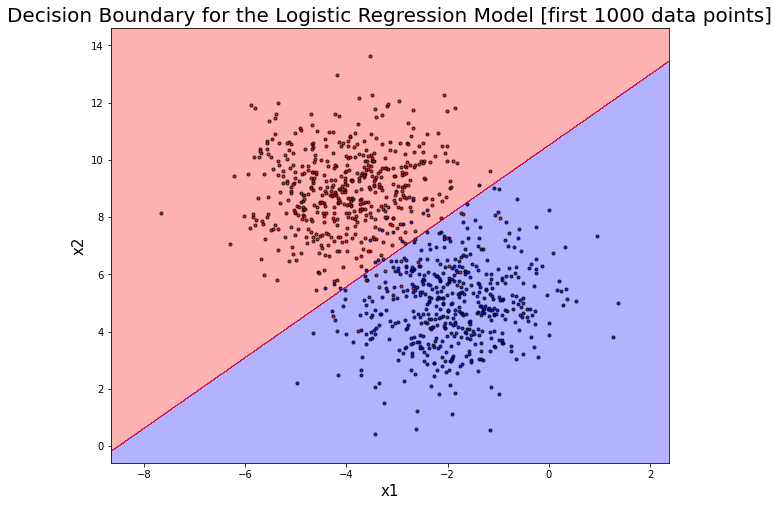

In [13]:
plot_decision_regions(X_train_1000, y_train_1000, lr_model)
plt.title('Decision Boundary for the Logistic Regression Model [first 1000 data points]', fontsize=20)
plt.xlabel('x1', fontsize=15)
plt.ylabel('x2', fontsize=15)
plt.show();

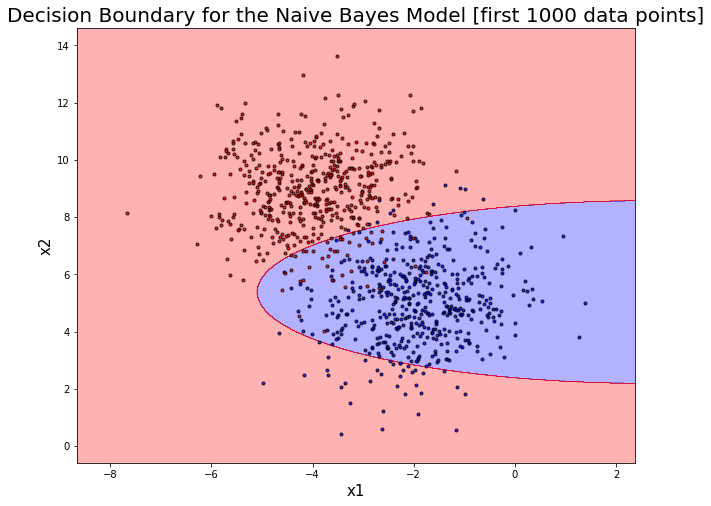

In [14]:
plot_decision_regions(X_train_1000, y_train_1000, nb_model)
plt.title('Decision Boundary for the Naive Bayes Model [first 1000 data points]', fontsize=20)
plt.xlabel('x1', fontsize=15)
plt.ylabel('x2', fontsize=15)
plt.show();

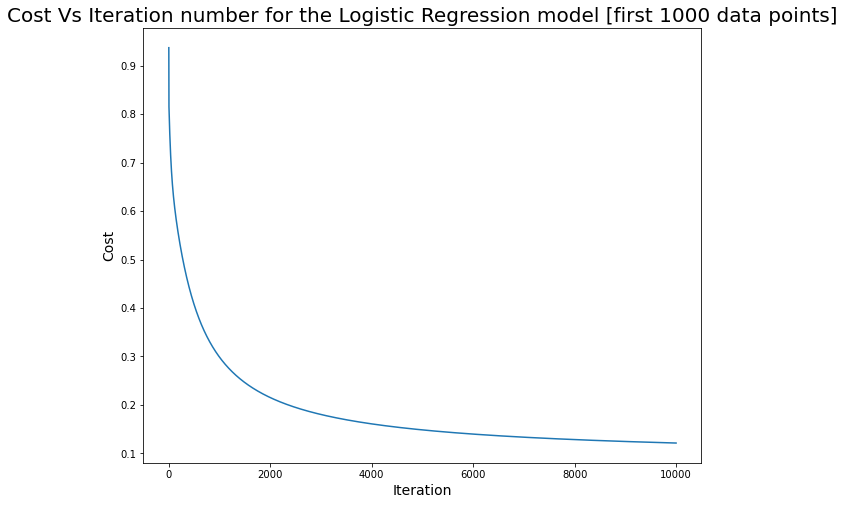

In [15]:
# cost vs the iteration number plot for the logistic regression model 
plt.plot(lr_model.J_history)
plt.title("Cost Vs Iteration number for the Logistic Regression model [first 1000 data points]", fontsize=20)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Cost", fontsize=14);

### USE OF all data points from train and test

In [16]:
#### Your code here ####

training_samples_num = len(y_training)
test_samples_num = len(y_test) 

### Logistic Regression ###
lr_model = LogisticRegressionGD(eta=best_eta, eps=best_eps)
lr_model.fit(X_training, y_training)

lr_train_preds = lr_model.predict(X_training)
lr_test_preds = lr_model.predict(X_test)

lr_train_accuracy = (y_training == lr_train_preds).sum() / training_samples_num
lr_test_accuracy = (y_test == lr_test_preds).sum() / test_samples_num

print('Logistic Regression Accuracies:')
print(f'Train: {lr_train_accuracy * 100}%')
print(f'Test: {lr_test_accuracy * 100}%')
print('*'*30)

## Naive Bayes ###
nb_model = NaiveBayesGaussian(k=2)
nb_model.fit(X_training, y_training)

nb_train_preds = nb_model.predict(X_training)
nb_test_preds = nb_model.predict(X_test)

nb_train_accuracy = (y_training == nb_train_preds).sum() / training_samples_num
nb_test_accuracy = (y_test == nb_test_preds).sum() / test_samples_num

print('Naive Bayes Accuracies:')
print(f'Train: {nb_train_accuracy * 100}%')
print(f'Test: {nb_test_accuracy * 100}%')



Logistic Regression Accuracies:
Train: 79.60000000000001%
Test: 79.2%
******************************
Naive Bayes Accuracies:
Train: 92.2%
Test: 89.9%


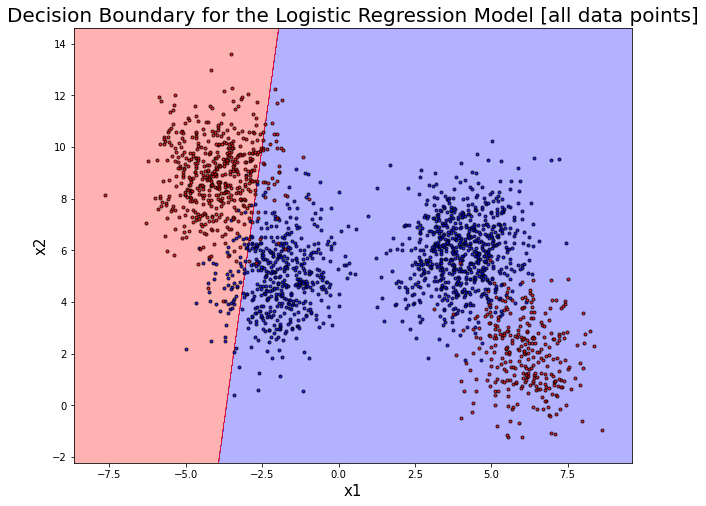

In [17]:
plot_decision_regions(X_training, y_training, lr_model)
plt.title('Decision Boundary for the Logistic Regression Model [all data points]', fontsize=20)
plt.xlabel('x1', fontsize=15)
plt.ylabel('x2', fontsize=15)
plt.show();

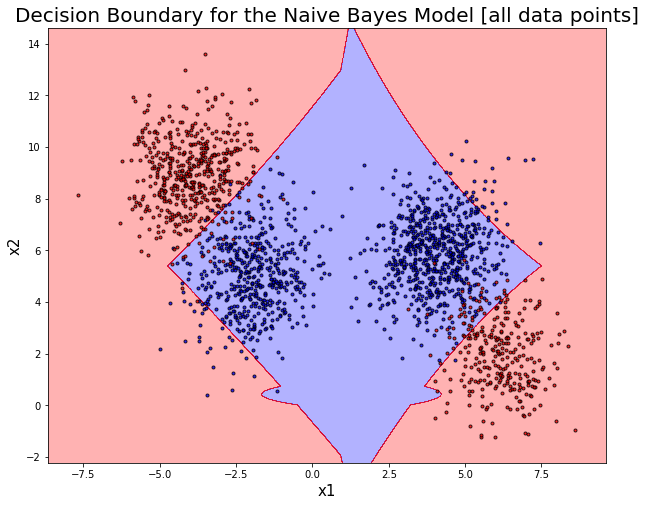

In [18]:
plot_decision_regions(X_training, y_training, nb_model)
plt.title('Decision Boundary for the Naive Bayes Model [all data points]', fontsize=20)
plt.xlabel('x1', fontsize=15)
plt.ylabel('x2', fontsize=15)
plt.show();

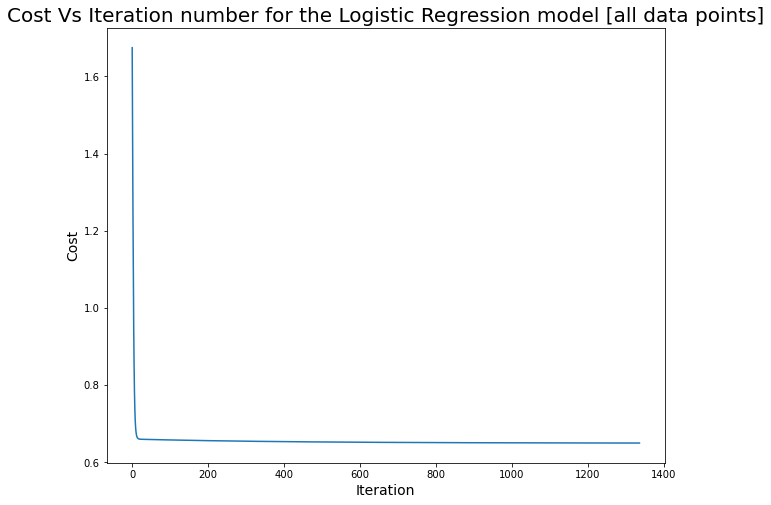

In [19]:
# cost vs the iteration number plot for the logistic regression model 
plt.plot(lr_model.J_history)
plt.title("Cost Vs Iteration number for the Logistic Regression model [all data points]", fontsize=20)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Cost", fontsize=14);

## Explanation of the graphs:

We can observe from the scatter plot of the first 1000 data points that the 2 classes are lineary separable, we will have some "misses" since there some points in the middle that overlap, but overall linear separability is quite good. But when we use all the data points, we can see that in this case we can not separate the classes using the straight line and as a result the perfomance of the Linear Regression Classifier is poor. We can also observe from the Cost vs Iteration number plots, that in the case of 1000 data points the cost reaches ~0.1, whereas in case of all data points it converged to ~0.65 and not decrease anymore, confiriming all the said above.

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####


In [20]:
from scipy.stats import multivariate_normal

# Naive Bayes better than Logisitc Regression dataset

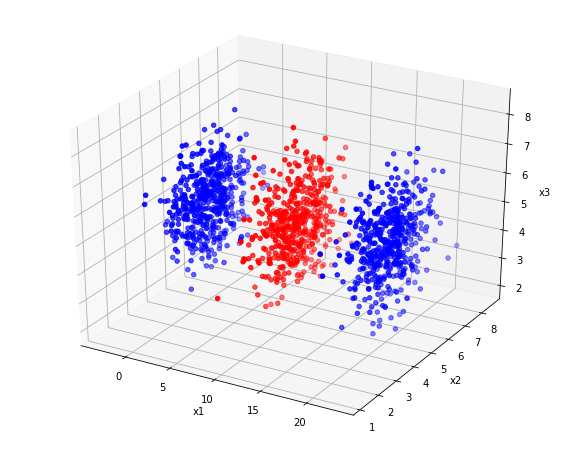

In [21]:
mean = [[0.0, 5, 5], [10.0, 5, 5], [20.0, 5, 5]]
cov = [[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]],
       [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], 
       [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]]

x_1 = []
x_2 = []
x_3 = []
y = []

c = ['b', 'r']

size = 500

ax = plt.axes(projection='3d')

for i in range(3):
    x1, x2, x3 = multivariate_normal(mean[i], cov[i]).rvs(size).T
    x_1.extend(x1)
    x_2.extend(x2)
    x_3.extend(x3)
    y.extend([i%2] * size)
    
    ax.scatter3D(x1, x2, x3, c=c[i%2])
    

NB_BETTER_THAN_LR_DF = pd.DataFrame(np.array([x_1, x_2, x_3, y]).T, columns=['x1', 'x2', 'x3', 'y'])


ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

plt.show()

# Logistic Regression better than Naive Bayes dataset

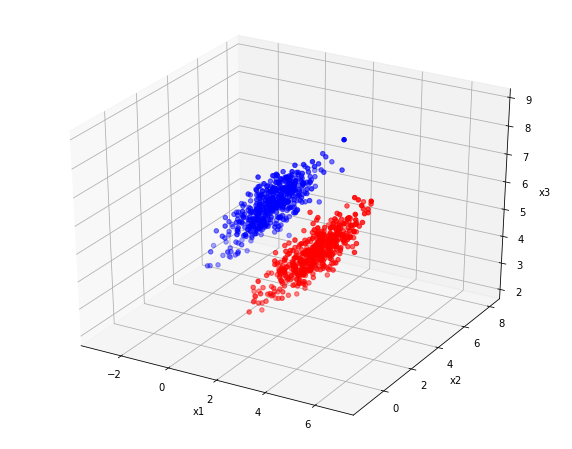

In [22]:
mean = [[0.0, 5, 5], [3.5, 2, 5]]
cov = [[[1.0, -0.4, 0.9], [-0.4, 1.0, -0.4], [0.9, -0.4, 1.0]],
       [[1.0, -0.4, 0.9], [-0.4, 1.0, -0.4], [0.9, -0.4, 1.0]]]

x_1 = []
x_2 = []
x_3 = []
y = []

c = ['b', 'r']

size = 500

ax = plt.axes(projection='3d')

for i in range(2):
    x1, x2, x3 = multivariate_normal(mean[i], cov[i]).rvs(size).T
    x_1.extend(x1)
    x_2.extend(x2)
    x_3.extend(x3)
    y.extend([i%2] * size)
    
    ax.scatter3D(x1, x2, x3, c=c[i%2])
    
    
LR_BETTER_THAN_NB_DF = pd.DataFrame(np.array([x_1, x_2, x_3, y]).T, columns=['x1', 'x2', 'x3', 'y'])


ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

plt.show()

## 2d graphs of all the features against each other

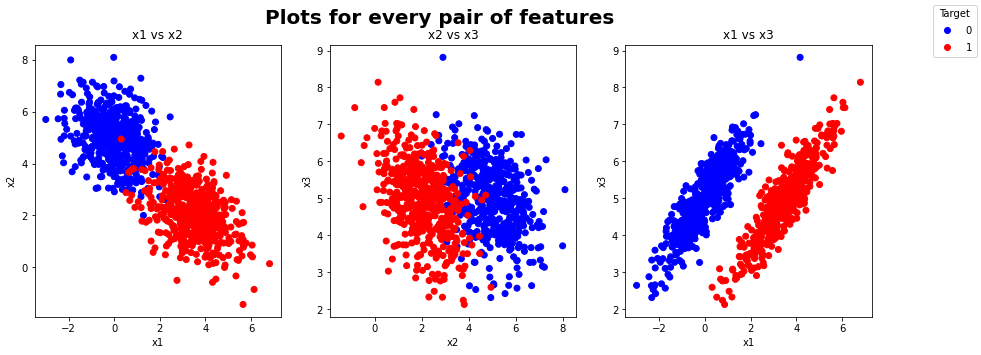

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

scatter1 = ax1.scatter(x_1, x_2, c=y, cmap='bwr')
scatter2 = ax2.scatter(x_2, x_3, c=y, cmap='bwr')
scatter3 = ax3.scatter(x_1, x_3, c=y, cmap='bwr')

ax1.set(title="x1 vs x2", xlabel='x1', ylabel='x2')
ax2.set(title="x2 vs x3", xlabel='x2', ylabel='x3')
ax3.set(title="x1 vs x3", xlabel='x1', ylabel='x3')


fig.legend(*scatter1.legend_elements(), title='Target', loc='upper right')
fig.suptitle('Plots for every pair of features', fontsize=20, fontweight='bold');

## Explanation

The first dataset in **not** lineary separable, we can clearly see that there is no plane that can separate blue and red points and as a result, the Logistic Regression will perform poorly on this dataset, having about 1/3 misses.
But Naive Bayes will perform much much better since it doesn't necessarily need linear separable data. In this case the data that labeled as '0' can be separated from both sides, leaving the '1' labeled data in the middle.

The second dataset is perfectly lineaerly separable and this will result in a perfect Linear Regression performance, since it will succeed to pass the plane between blue and red points.
But this time, Naive Bayes will perform less efficiently since it assumes conditional independence between the features, that in this dataset are clearly dependent.